In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using Plots
using Test
include("car.jl");
using ForwardDiff

  Activating environment at `~/convoy_ws/Project.toml`
  Activating environment at `~/convoy_ws/Project.toml`


In [2]:
# Define the model
model = BicycleModel()

# get the number of states and controls
n = state_dim(model)
m = control_dim(model)

# Evaluate the continuous and discrete dynamics
x0 = SA[0.,0.,0.,0.]
u0 = SA[0.,0.]
t0 = 0.0
dt = 0.025 
dynamics(model, x0, u0)
discrete_dynamics(RK4, model, x0, u0, t0, dt)  # use rk4 for integration

# Evaluate the continuous and discrete Jacobians
z0 = KnotPoint(x0,u0,dt,t0)   # create a `KnotPoint` type that stores everything together
∇f = RobotDynamics.DynamicsJacobian(model)
jacobian!(∇f, model, z0)
discrete_jacobian!(RK4, ∇f, model, z0)

# Extract pieces of the Jacobian
A = ∇f.A
B = ∇f.B;

In [3]:
nx = n
nu = m

Q = Diagonal([1,1,1e-2,1e-2])
R = Diagonal([1e-1,1e-1])
Qf = Diagonal([1,1,1,1.])*10

N = 401
Nmpc = 80
Nhz = 10
delta = 100
Nc = N + 2*delta

FD = ForwardDiff;

In [29]:
function get_path()
    x1ref = zeros(Nc)*NaN
    x2ref = zeros(Nc)*NaN
    θref = zeros(Nc)*NaN
    v1ref = zeros(Nc)*NaN
    v2ref = zeros(Nc)*NaN
    ωref = zeros(Nc)*NaN
    rad = 20
    
    u1ref = zeros(Nc-1)*NaN
    u2ref = zeros(Nc-1)*NaN
    
    for i = 1:Nc
        θref[i] = 2*pi*(i-Nc)/(Nc-1)
        x1ref[i] = rad * sin(θref[i])
        x2ref[i] = rad - rad * cos(θref[i])
    end
    
    for i = 1:Nc-1
        v1ref[i] = 0.0
        u1ref[i] = sqrt((x1ref[i+1] - x1ref[i])^2 + (x2ref[i+1] - x2ref[i])^2)/dt
        u2ref[i] = 0.0
    end
    v1ref[Nc] = v1ref[Nc-1]
    
    xref = [x1ref'; x2ref'; θref'; v1ref']
    uref = [u1ref'; u2ref']
    return [x for x in eachcol(xref)], [u for u in eachcol(uref)]
end

get_path (generic function with 1 method)

In [30]:
# Plot the reference trajectory and compare with the given plot
Xref, Uref = get_path()
Xref1 = Xref[1+2*delta:Nc]
Xref2 = Xref[1+delta:Nc-delta]
Xref3 = Xref[1:Nc-2*delta]

# convert to static arrays and plot
Xref1 = [SVector{4}(Xref1[i]) for i = 1:length(Xref1)]
Xref2 = [SVector{4}(Xref2[i]) for i = 1:length(Xref2)]
Xref3 = [SVector{4}(Xref3[i]) for i = 1:length(Xref3)]
Xref = [SVector{4}(Xref[i]) for i = 1:length(Xref)]
tref = SA[0:dt:(Nc-1-2*delta)*dt]
trefu = SA[0:dt:(Nc-2-2*delta)*dt]

Uref1 = Uref[1+2*delta:Nc-1]
Uref2 = Uref[1+delta:Nc-1-delta]
Uref3 = Uref[1:Nc-1-2*delta]

Uref1 = [SVector{2}(Uref1[i]) for i = 1:length(Uref1)]
Uref2 = [SVector{2}(Uref2[i]) for i = 1:length(Uref2)]
Uref3 = [SVector{2}(Uref3[i]) for i = 1:length(Uref3)]
Uref = [SVector{2}(Uref[i]) for i = 1:length(Uref)];

## The Reference Trajectory
In this problem we'll be tracking a reference trajectory generated via trajectory optimization. The code below loads the reference trajectory, plots it using `Plots.jl` (and some custom plotting recipes in `RobotDynamics`) and visualizes it using MeshCat.

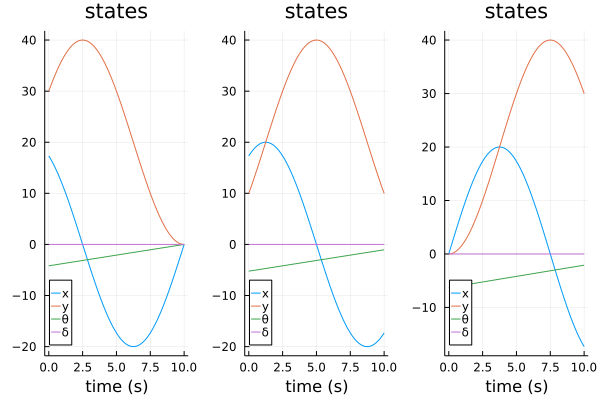

In [31]:
# Plot the states
p = plot(layout=(1,3))
plot!(p[1], tref, Xref1, inds=1:4, labels=["x" "y" "θ" "δ"], legend=:bottomleft, title="states", xlabel="time (s)")
plot!(p[2], tref, Xref2, inds=1:4, labels=["x" "y" "θ" "δ"], legend=:bottomleft, title="states", xlabel="time (s)")
plot!(p[3], tref, Xref3, inds=1:4, labels=["x" "y" "θ" "δ"], legend=:bottomleft, title="states", xlabel="time (s)")

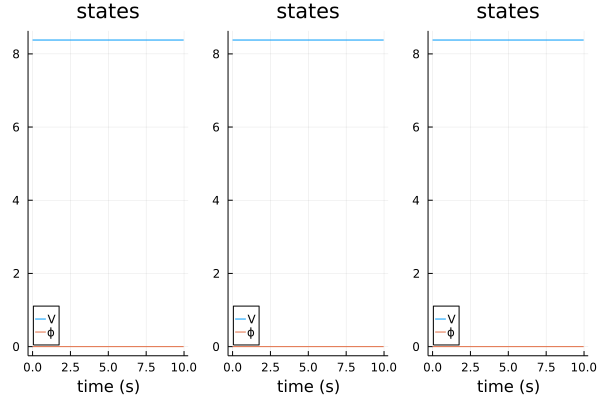

In [32]:
# Plots the controls
p = plot(layout=(1,3))
plot!(p[1], trefu, Uref1, inds=1:2, labels=["V" "ϕ"], legend=:bottomleft, title="states", xlabel="time (s)")
plot!(p[2], trefu, Uref2, inds=1:2, labels=["V" "ϕ"], legend=:bottomleft, title="states", xlabel="time (s)")
plot!(p[3], trefu, Uref3, inds=1:2, labels=["V" "ϕ"], legend=:bottomleft, title="states", xlabel="time (s)")

In [33]:
Q = Diagonal([10,10,10,1.])
R = Diagonal([1.,1.])
Qf = Diagonal([1,1,1,1.])*1;

In [34]:
function stage_cost(x,u,xref,uref, Q, R, Qf)
    # LQR cost at each knot point (depends on both x and u)
    J = 0.5 * (x - xref)' * Q * (x - xref) + 0.5 * (u - uref)' * R * (u - uref)
    
    return J
end

function term_cost(x,xref, Q, R, Qf)
    # LQR terminal cost (depends on just x)
    J = 0.5 * (x - xref)' * Qf * (x - xref)
    
    return J
end

function trajectory_cost(X,U,Xref,Uref, Q, R, Qf, Nmpc)
    # calculate the cost of a given trajectory 
    J = 0.0
    for i = 1:Nmpc-1
        J += stage_cost(X[i],U[i],Xref[i],Uref[i], Q, R, Qf)
    end
    J += term_cost(X[end], Xref[end], Q, R, Qf)
    
    return J
end
        
function stage_cost_expansion(x,u,xref,uref, Q, R, Qf, Nmpc)
    # if the stage cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ, ∇²ᵤJ, ∇ᵤJ
    Jxx = Q
    Jx = Q * (x - xref)
    Juu = R
    Ju = R * (u - uref)
    
    return Jxx, Jx, Juu, Ju
end

function term_cost_expansion(x,xref, Q, R, Qf, Nmpc)
    # if the terminal cost function is J, return the following derivatives:
    # ∇²ₓJ,  ∇ₓJ
    Jxx = Qf
    Jx = Qf * (x - xref)
    
    return Jxx, Jx
end

term_cost_expansion (generic function with 1 method)

In [35]:
function dynamics_jacobians(x,u,dt)
    # returns the discrete time dynamics jacobians
    A = FD.jacobian(_x -> discrete_dynamics(RK4, model, _x, u, t0, dt),x)
    B = FD.jacobian(_u -> discrete_dynamics(RK4, model, x, _u, t0, dt),u)
    return A,B
end

dynamics_jacobians (generic function with 1 method)

In [36]:
function backward_pass(X,U,Xref,Uref, Q, R, Qf, Nmpc)

    # allocate all our data
    P = [zeros(nx,nx) for i = 1:Nmpc]     # cost to go quadratic term
    p = [zeros(nx) for i = 1:Nmpc]        # cost to go linear term 
    d = [zeros(nu)*NaN for i = 1:Nmpc-1]  # feedforward control
    K = [zeros(nu,nx) for i = 1:Nmpc-1]   # feedback gain
    ΔJ = 0.0                           # expected cost decrease
    
    P[Nmpc], p[Nmpc] = term_cost_expansion(X[Nmpc],Xref[Nmpc], Q, R, Qf, Nmpc)
    for i in reverse(1:Nmpc-1)
        A, B = dynamics_jacobians(X[i],U[i],dt)
        lxx, lx, luu, lu = stage_cost_expansion(X[i],U[i],Xref[i],Uref[i], Q, R, Qf, Nmpc)
        gx = lx + A'*p[i+1]
        gu = lu + B'*p[i+1]
        Gxx = lxx + A'*P[i+1]*A
        Guu = luu + B'*P[i+1]*B
        Gxu = A'*P[i+1]*B
        Gux = B'*P[i+1]*A
        d[i] = inv(Guu)*gu
        K[i] = inv(Guu)*Gux
        P[i] = Gxx + K[i]'*Guu*K[i] - Gxu*K[i] - K[i]'*Gux
        p[i] = gx - K[i]'*gu + K[i]'Guu*d[i] - Gxu*d[i]
        ΔJ += gu'*d[i]
    end
    
    return d, K, P, ΔJ
end

backward_pass (generic function with 1 method)

In [37]:
function forward_pass(X,U,Xref,Uref,K,d,ΔJ, Q, R, Qf, Nmpc; max_linesearch_iters = 100)
    
    Xn = deepcopy(X)
    Un = deepcopy(U)
    Jn = trajectory_cost(Xn,Un,Xref,Uref, Q, R, Qf, Nmpc)
    J = trajectory_cost(X,U,Xref,Uref, Q, R, Qf, Nmpc)
    α = 2
    iters = 0
    
    while Jn >= J - 0.002*α*ΔJ && iters < max_linesearch_iters
        α *= 0.5
        Xn = deepcopy(X)
        Un = deepcopy(U)
        for i = 1:Nmpc-1
            Un[i] = U[i] - α*d[i] - K[i]*(Xn[i]-X[i])
            Xn[i+1] = discrete_dynamics(RK4, model, Xn[i], Un[i], t0, dt)
        end
        J = trajectory_cost(X,U,Xref,Uref, Q, R, Qf, Nmpc)
        Jn = trajectory_cost(Xn,Un,Xref,Uref, Q, R, Qf, Nmpc)
        iters += 1
    end
        
    return Xn, Un, Jn, α
end

forward_pass (generic function with 1 method)

In [38]:
function iLQR(x0,U,Xref,Uref, Q, R, Qf, Nmpc;atol=0.3,max_iters = 40,verbose = true)
    X = [x0 for i = 1:Nmpc]
    U = U
    K = [zeros(nu,nx)*NaN for i = 1:Nmpc-1]
    P = [zeros(nx,nx)*NaN for i = 1:Nmpc]
    iter = -1
    max_norm = 10000
    
    while(iter < max_iters && max_norm > atol)
        d, K, P, ΔJ = backward_pass(X,U,Xref,Uref, Q, R, Qf, Nmpc)
        X, U, Jr, α = forward_pass(X,U,Xref,Uref,K,d,ΔJ, Q, R, Qf, Nmpc)
        iter += 1
        max_norm = max(norm(d))
    end

    return X,U,K,P,iter

end

iLQR (generic function with 1 method)

In [39]:
function get_closest_index(x, Xref)
    min_val = 1000000
    min_idx = 0
    for i = 1:length(Xref)
        x2 = Xref[i]
        dist = sqrt((x[1]-x2[1])^2 + (x[2]-x2[2])^2 + 10*(x[3]-x2[3])^2)
        if dist < min_val
            min_val = dist
            min_idx = i
        end
    end
    return min_idx
end

function getXUmpc(x, u, Xref, Uref, i, Nhz, Nmpc, Nc)
    k = get_closest_index(x, Xref)
    if i-k > 0.5*Nc
        k = Nc
    end
    Xrefmpc = [SVector{4}(Xref[j]) for j = k:min(Nmpc+k, Nc)]
    Urefmpc = [SVector{2}(Uref[j]) for j = k:min(Nmpc+k, Nc)-1]
    U0ref = [SVector{2}(u) for j = k:Nmpc+k-1]
    append!(Urefmpc, [SVector{2}([0., 0.]) for j = min(Nmpc, Nc-k):Nmpc-1])
    append!(Xrefmpc, [SVector{4}(Xref[end]) for j = min(Nmpc, Nc-k):Nmpc])
    Xrefmpc[1] = x
    Urefmpc[1] = u
   
    return Xrefmpc, Urefmpc, U0ref
end

getXUmpc (generic function with 1 method)

In [40]:
function ilqr_mpc(Xref, Uref, start, Q, R, Qf, Nhz, Nmpc, Nc)
    Xline = []
    Uline = []
    XLast = Xref[start]
    ULast = Uref[start]
    for i = start:Nhz:Nc-1
        Xrefmpc, Urefmpc, U0ref = getXUmpc(XLast, ULast, Xref, Uref, i, Nhz, Nmpc, Nc)
        Xmpc,Umpc,Kmpc,Pmpc, itermpc = iLQR(Xrefmpc[1],U0ref,Xrefmpc,Urefmpc, Q, R, Qf, Nmpc)
        append!(Xline, Xmpc[1:Nhz])
        append!(Uline, Umpc[1:Nhz])
        XLast = Xmpc[Nhz+1]
        ULast = Umpc[Nhz+1]
    end
    return Xline, Uline
end

function ilqr_mpc_3(Xref, Uref, start, Q, R, Qf, Nhz, Nmpc, Nc, delta)
    Xline1 = []
    Uline1 = []
    Xline2 = []
    Uline2 = []
    Xline3 = []
    Uline3 = []
    XLast3 = Xref[start]
    ULast3 = Uref[start]
    XLast2 = Xref[start+delta]
    ULast2 = Uref[start+delta]
    XLast1 = Xref[start+2*delta]
    ULast1 = Uref[start+2*delta]
    for i = start:Nhz:Nc-1
        Xrefmpc1, Urefmpc1, U0ref1 = getXUmpc(XLast1, ULast1, Xref, Uref, i, Nhz, Nmpc, Nc)
        Xmpc1,Umpc1,Kmpc1,Pmpc1, itermpc1 = iLQR(Xrefmpc1[1],U0ref1,Xrefmpc1,Urefmpc1, Q, R, Qf, Nmpc)
        
        Xrefmpc2, Urefmpc2, U0ref2 = getXUmpc(XLast2, ULast2, Xref, Uref, i+delta, Nhz, Nmpc, Nc)
        Xmpc2,Umpc2,Kmpc2,Pmpc2, itermpc2 = iLQR(Xrefmpc2[1],U0ref2,Xrefmpc2,Urefmpc2, Q, R, Qf, Nmpc)
        
        Xrefmpc3, Urefmpc3, U0ref3 = getXUmpc(XLast3, ULast3, Xref, Uref, i+2*delta, Nhz, Nmpc, Nc)
        Xmpc3,Umpc3,Kmpc3,Pmpc3, itermpc3 = iLQR(Xrefmpc3[1],U0ref3,Xrefmpc3,Urefmpc3, Q, R, Qf, Nmpc)
        
        append!(Xline1, Xmpc1[1:Nhz])
        append!(Uline1, Umpc1[1:Nhz])
        XLast1 = Xmpc1[Nhz+1]
        ULast1 = Umpc1[Nhz+1]
        
        append!(Xline2, Xmpc2[1:Nhz])
        append!(Uline2, Umpc2[1:Nhz])
        XLast2 = Xmpc2[Nhz+1]
        ULast2 = Umpc2[Nhz+1]
        
        append!(Xline3, Xmpc3[1:Nhz])
        append!(Uline3, Umpc3[1:Nhz])
        XLast3 = Xmpc3[Nhz+1]
        ULast3 = Umpc3[Nhz+1]
    end
    return Xline1, Uline1, Xline2, Uline2, Xline3, Uline3
end

ilqr_mpc_3 (generic function with 1 method)

In [41]:
Q = Diagonal([1,1,10,10.])
R = Diagonal([1.,10.])
Qf = Diagonal([1,1,1,1.])*2;

In [42]:
Xline1, Uline1, Xline2, Uline2, Xline3, Uline3 = ilqr_mpc_3(Xref, Uref, 1, Q, R, Qf, Nhz, Nmpc, Nc, 60);

In [43]:
Xline1 = [SVector{4}(Xline1[i]) for i = 1:length(Xline1)]
Uline1 = [SVector{2}(Uline1[i]) for i = 1:length(Uline1)]
Xline2 = [SVector{4}(Xline2[i]) for i = 1:length(Xline2)]
Uline2 = [SVector{2}(Uline2[i]) for i = 1:length(Uline2)]
Xline3 = [SVector{4}(Xline3[i]) for i = 1:length(Xline3)]
Uline3 = [SVector{2}(Uline3[i]) for i = 1:length(Uline3)];

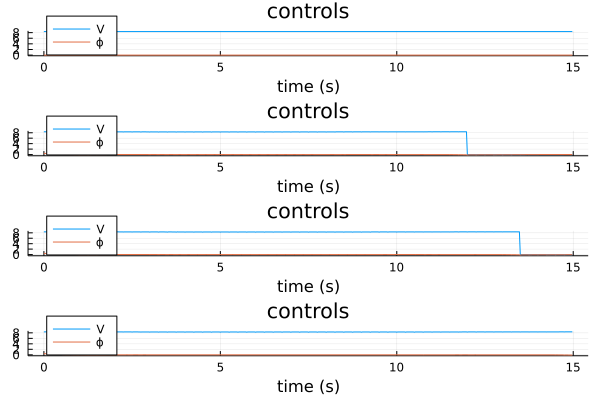

In [44]:
trefU = SA[0:dt:(Nc-2)*dt]
p = plot(layout=(4,1))
plot!(p[1], trefU, Uref, inds=1:2, labels=["V" "ϕ"], legend=:bottomleft, title="controls", xlabel="time (s)")
plot!(p[2], trefU, Uline1, inds=1:2, labels=["V" "ϕ"], legend=:bottomleft, title="controls", xlabel="time (s)")
plot!(p[3], trefU, Uline2, inds=1:2, labels=["V" "ϕ"], legend=:bottomleft, title="controls", xlabel="time (s)")
plot!(p[4], trefU, Uline3, inds=1:2, labels=["V" "ϕ"], legend=:bottomleft, title="controls", xlabel="time (s)")

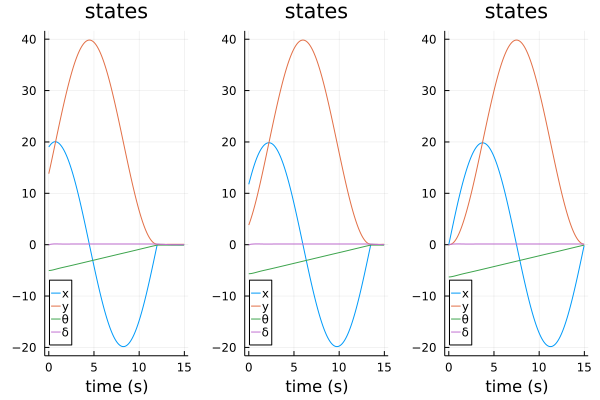

In [45]:
trefN = SA[0:dt:(Nc-1)*dt]
p = plot(layout=(1,3))
# plot!(p[1], trefN, Xref, inds=1:4, labels=["x" "y" "θ" "δ"], legend=:bottomleft, title="states", xlabel="time (s)")
plot!(p[1], trefU, Xline1, inds=1:4, labels=["x" "y" "θ" "δ"], legend=:bottomleft, title="states", xlabel="time (s)")
plot!(p[2], trefU, Xline2, inds=1:4, labels=["x" "y" "θ" "δ"], legend=:bottomleft, title="states", xlabel="time (s)")
plot!(p[3], trefU, Xline3, inds=1:4, labels=["x" "y" "θ" "δ"], legend=:bottomleft, title="states", xlabel="time (s)")

In [38]:
function diff_dist(Xline1, Xline2, Xref)
    len_dist = length(Xline1)
    dist = zeros(len_dist)*NaN
    for i = 1:length(Xline1)
        idx1 = get_closest_index(Xline1[i], Xref)
        idx2 = get_closest_index(Xline2[i], Xref)
        dist[i] = idx2 - idx1
    end
    return dist
end

diff_dist (generic function with 2 methods)

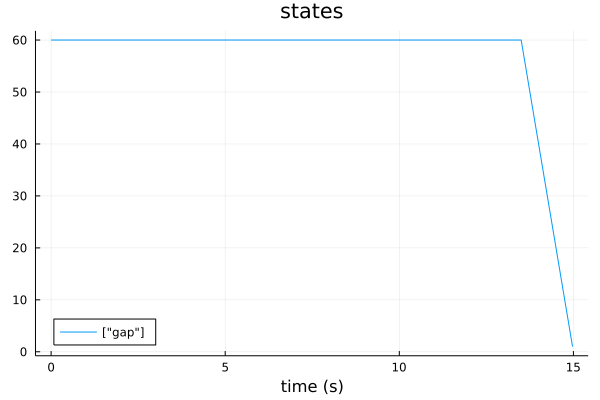

In [39]:
XDiff = diff_dist(Xline1, Xline2, Xref)
XDiff = [SVector{1}(XDiff[i]) for i = 1:length(XDiff)]
p = plot(layout=(1,1))
plot!(p[1], trefU, XDiff, labels=["gap"], legend=:bottomleft, title="states", xlabel="time (s)")

In [30]:
# Visualize in MeshCat
if true
    vis = initialize_visualizer(model)
    render(vis)
end

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/nambags/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("chassis" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x6d, 0x2f, 0x63, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("body" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x73, 0x73, 0x69, 0x73, 0x2f, 0x62, 0x6f, 0x64, 0x79], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x73, 0x69, 0x73, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "front" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x66, 0x72, 0x6f, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x6e, 0x74, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))))), Set{Any}(), ip"127.0.0.1", 8700))

In [31]:
# send trajectory to the visualizer
visualize!(vis, model, (Nc-1)*dt, Xline)

In [217]:
# display a new visualizer pane
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("robot" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geom" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x72, 0x6f, 0x62, 0x6f, 0x74, 0x2f, 0x67, 0x65, 0x6f, 0x6d], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("chassis" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x6d, 0x2f, 0x63, 0x68, 0x61, 0x73, 0x73, 0x69, 0x73], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("body" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x73, 0x73, 0x69, 0x73, 0x2f, 0x62, 0x6f, 0x64, 0x79], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x73, 0x69, 0x73, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "front" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x2f, 0x66, 0x72, 0x6f, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("wheel" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x72, 0x6f, 0x6e, 0x74, 0x2f, 0x77, 0x68, 0x65, 0x65, 0x6c], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))))), Set(Any[WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED), WebSocket(server, CONNECTED)]), ip"127.0.0.1", 8700))

In [301]:
# Send the trajectory to the visualizer
visualize!(vis, model, (Nc-1)*dt, Xref3)

In [317]:
# Xline,Uline,Kline,Pline, iterline = iLQR(Xref1[1],Uref1,Xref1,Uref);
# Xline,Uline,Kline,Pline, iterline = iLQR(Xref2[1],Uref2,Xref2,Uref);
Xline,Uline,Kline,Pline, iterline = iLQR(Xref3[1],Uref3,Xref3,Uref);

LoadError: BoundsError: attempt to access 20-element Vector{SVector{4, Float64}} at index [21]

In [17]:
Xline, Uline = ilqr_mpc(Xref, Uref, 1, Q, R, Qf, Nhz, Nmpc, Nc);

In [18]:
Xline = [SVector{4}(Xline[i]) for i = 1:length(Xline)]
Uline = [SVector{2}(Uline[i]) for i = 1:length(Uline)];

In [46]:
savefig("/home/nambags/convoy_ws/states")

In [49]:
@show Xline3

Xline3 = SVector{4, Float64}[[4.898587196589413e-15, 0.0, -6.283185307179586, 0.0], [0.20879192403619107, 0.0006809327246015724, -6.2827514718758115, 0.011220105579636826], [0.41775533611448123, 0.0028072256691008416, -6.281473748104213, 0.021795077532111733], [0.6268663689649022, 0.006479101763207477, -6.279399543202991, 0.03175286560842548], [0.8360986497517742, 0.01178998635594488, -6.276574383197173, 0.04111937009632871], [1.04542352706589, 0.018826608180617658, -6.273042056093305, 0.049919008806372955], [1.254810343226173, 0.027669137860927246, -6.268844709271711, 0.05817513337463799], [1.4642267299464566, 0.0383913594770273, -6.264022912677748, 0.06591032477743225], [1.67363890981838, 0.05106087048782942, -6.258615697576321, 0.07314659318455392], [1.8830119901697198, 0.0657393051117183, -6.252660578896583, 0.07990550318390396], [2.0923102395639774, 0.08248257616892518, -6.2461935676403035, 0.0862082418943303], [2.3020952118678926, 0.10168907274949446, -6.239042032338416, 0.096831

600-element Vector{SVector{4, Float64}}:
 [4.898587196589413e-15, 0.0, -6.283185307179586, 0.0]
 [0.20879192403619107, 0.0006809327246015724, -6.2827514718758115, 0.011220105579636826]
 [0.41775533611448123, 0.0028072256691008416, -6.281473748104213, 0.021795077532111733]
 [0.6268663689649022, 0.006479101763207477, -6.279399543202991, 0.03175286560842548]
 [0.8360986497517742, 0.01178998635594488, -6.276574383197173, 0.04111937009632871]
 [1.04542352706589, 0.018826608180617658, -6.273042056093305, 0.049919008806372955]
 [1.254810343226173, 0.027669137860927246, -6.268844709271711, 0.05817513337463799]
 [1.4642267299464566, 0.0383913594770273, -6.264022912677748, 0.06591032477743225]
 [1.67363890981838, 0.05106087048782942, -6.258615697576321, 0.07314659318455392]
 [1.8830119901697198, 0.0657393051117183, -6.252660578896583, 0.07990550318390396]
 [2.0923102395639774, 0.08248257616892518, -6.2461935676403035, 0.0862082418943303]
 [2.3020952118678926, 0.10168907274949446, -6.239042032338